# Image Classification for Skin Cancer

## Decision Tree

### Load Data for Decision Tree and preprocess for training.
Ayan

In [ ]:
# access gdrive to grab images
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CPS4801/final-project/data

Mounted at /content/drive
/content/drive/MyDrive/CPS4801/final-project/data


In [ ]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# 1.
# Function to load images from a folder and assign labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

# Load images and assign labels
images_malignant, labels_malignant = load_images_from_folder('malignant', 1)
images_benign, labels_benign = load_images_from_folder('benign', 0)

# Combine images and labels
images = images_malignant + images_benign
labels = labels_malignant + labels_benign

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
# Convert images to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Flatten images so 2d array of pixels goes to 1d to pass into decision tree training func
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

### Train Decision Tree
Ayan

In [ ]:
# Train decision tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)


DecisionTreeClassifier()

### Evaluate Decision Tree using precision and Recall
Ayan

In [ ]:
# Evaluate model
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)

Confusion Matrix:
[[271  70]
 [ 88 231]]
Precision: 0.7674418604651163
Recall: 0.7241379310344828


### Run uncertainty measure of Decision tree

Chigozie

In [ ]:
from math import log2

# Function to calculate entropy
def entropy(labels):
    class_counts = np.unique(labels, return_counts=True)[1]
    total_samples = np.sum(class_counts)
    entropy = 0
    for count in class_counts:
        probability = count / total_samples
        entropy -= probability * log2(probability)
    return entropy

# Predict class labels for the test set
y_pred = model.predict(X_test)

# Calculate entropy for the predicted class labels
entropy_value = entropy(y_pred)

print("Entropy:", entropy_value)

Entropy: 0.9944220705380191


## Deep Learning Model with Resnet-50

### Load Data for deep learning
Amir

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import torch
from sklearn.model_selection import train_test_split

# load dataset
def load_images_and_labels(base_path, class_label):
    images = []
    labels = []
    for filename in os.listdir(base_path):
        filepath = os.path.join(base_path, filename)
        if filepath.endswith(".jpg"):
              images.append(filepath)
              labels.append(class_label)
    return images, labels

# Paths to the 'early' and 'benign' image folders
malignant_image, malignant_label = load_images_and_labels('./malignant', 0)  # Update this path
benign_image, benign_label = load_images_and_labels('./benign', 1) # Update this path
print(malignant_image)
print(malignant_label)
print(benign_image)
print(benign_label)

images = malignant_image + benign_image
labels = malignant_label + benign_label

# Split dataset into train and test
train_images, test_images, train_labels, test_labels = train_test_split(
            images, labels, test_size=0.2, random_state=42
        )

# Important CustomDataset!!
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Create transforms
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create an object of the dataset
train_dataset = CustomDataset(train_images, train_labels, transform=data_transform)
test_dataset = CustomDataset(test_images, test_labels, transform=data_transform)

print(len(train_dataset))
print(len(test_dataset))

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

['./malignant/1219.jpg', './malignant/1263.jpg', './malignant/1239.jpg', './malignant/1249.jpg', './malignant/1246.jpg', './malignant/1252.jpg', './malignant/1261.jpg', './malignant/1240.jpg', './malignant/1253.jpg', './malignant/1212.jpg', './malignant/1230.jpg', './malignant/1233.jpg', './malignant/1264.jpg', './malignant/1235.jpg', './malignant/1269.jpg', './malignant/1223.jpg', './malignant/1255.jpg', './malignant/1244.jpg', './malignant/1222.jpg', './malignant/1224.jpg', './malignant/122.jpg', './malignant/123.jpg', './malignant/1231.jpg', './malignant/1232.jpg', './malignant/125.jpg', './malignant/1225.jpg', './malignant/1260.jpg', './malignant/1241.jpg', './malignant/1247.jpg', './malignant/1214.jpg', './malignant/1265.jpg', './malignant/1259.jpg', './malignant/124.jpg', './malignant/126.jpg', './malignant/1210.jpg', './malignant/1250.jpg', './malignant/1213.jpg', './malignant/1226.jpg', './malignant/1305.jpg', './malignant/1272.jpg', './malignant/1306.jpg', './malignant/1315.jp

### Create resnet-50 model, optimizer and loss function.
Amir

In [ ]:
# install timm
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
model_resnet = timm.create_model('resnet50', pretrained=True, num_classes=2)
model_resnet = model_resnet.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001)

### Train deep learning model
Amir

Testing: 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]


Epoch 1, Train Loss: 0.5883381445723844, Test Loss: 0.4537299289589837, Test Accuracy: 85.0%


Testing: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]


Epoch 2, Train Loss: 0.3735329490828227, Test Loss: 0.30649860274224056, Test Accuracy: 85.75757575757575%


Testing: 100%|██████████| 21/21 [00:04<00:00,  4.26it/s]


Epoch 3, Train Loss: 0.2699944093284837, Test Loss: 0.30929018344197956, Test Accuracy: 84.6969696969697%


Testing: 100%|██████████| 21/21 [00:04<00:00,  4.38it/s]


Epoch 4, Train Loss: 0.22934481725994363, Test Loss: 0.2655544071680024, Test Accuracy: 87.57575757575758%


Testing: 100%|██████████| 21/21 [00:04<00:00,  4.42it/s]


Epoch 5, Train Loss: 0.16423188100557728, Test Loss: 0.2631238329978216, Test Accuracy: 88.03030303030303%


Testing: 100%|██████████| 21/21 [00:04<00:00,  4.49it/s]


Epoch 6, Train Loss: 0.1309022109910666, Test Loss: 0.2598688652118047, Test Accuracy: 88.48484848484848%


Testing: 100%|██████████| 21/21 [00:04<00:00,  4.44it/s]


Epoch 7, Train Loss: 0.08425361979528363, Test Loss: 0.43990678446633474, Test Accuracy: 84.24242424242425%


Testing: 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]


Epoch 8, Train Loss: 0.05643916031323284, Test Loss: 0.33081438002132235, Test Accuracy: 88.93939393939394%


Testing: 100%|██████████| 21/21 [00:04<00:00,  4.23it/s]


Epoch 9, Train Loss: 0.0519961562787508, Test Loss: 0.38905573742730276, Test Accuracy: 86.36363636363636%


Testing: 100%|██████████| 21/21 [00:05<00:00,  4.14it/s]


Epoch 10, Train Loss: 0.024852808837004633, Test Loss: 0.4847546970205648, Test Accuracy: 86.51515151515152%
Finished Training


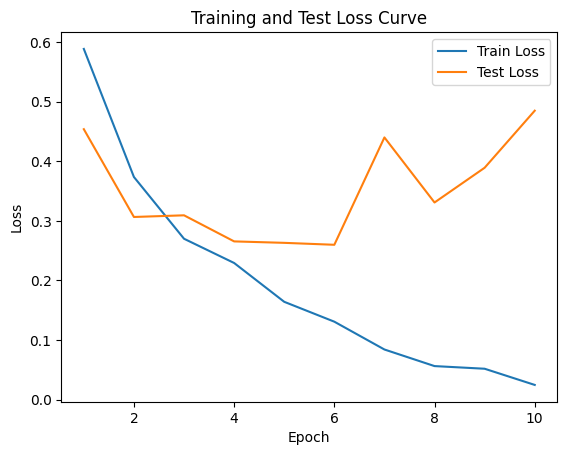

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

train_losses = []
test_losses = []
num_epochs = 10
# Training loop
for epoch in range(num_epochs):
    model_resnet.train()  # Set the model to training mode
    running_train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to("cuda"), labels.to("cuda")  # Move data to the appropriate device
        # 1.
        optimizer.zero_grad()
        # 2. forward
        outputs = model_resnet(images)
        # 3. compute loss
        loss = criterion(outputs, labels)
        # 4. backward
        loss.backward()
        # 5. Train
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Evaluate on test set
    model_resnet.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to("cuda"), labels.to("cuda")  # Move data to the appropriate device

            outputs = model_resnet(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_test_loss = running_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Test Loss: {epoch_test_loss}, Test Accuracy: {100 * correct / total}%")

print('Finished Training')

# Save model
torch.save(model, "resnet50.pth")

# Plotting the loss curve
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.show()

### Evaluate using Iou and precision and recall of Resnet-50

Amir

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model_resnet.eval()

# Initialize lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Iterate through the test dataset to collect predictions and ground truth labels
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)

print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)

Evaluating: 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]

Confusion Matrix:
[[305  14]
 [ 75 266]]
Precision: 0.95
Recall: 0.7800586510263929


### Uncertainty Measure of resnet-50

Chigozie

In [ ]:
import torch.nn.functional as F

# Function to calculate entropy
def entropy(logits):
    probabilities = F.softmax(logits, dim=1)
    log_probabilities = F.log_softmax(logits, dim=1)
    entropy = -(probabilities * log_probabilities).sum(dim=1)
    return entropy.mean().item()

# Evaluation loop
entropies = []
model_resnet.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to("cuda"), labels.to("cuda")  # Move data to the appropriate device

        outputs = model_resnet(images)
        entropies.append(entropy(outputs))

# Average entropy over the test set
average_entropy = np.mean(entropies)
print("\nAverage entropy:", average_entropy)

Testing: 100%|██████████| 21/21 [00:05<00:00,  4.02it/s]


Average entropy: 0.1231112971547104
